# Introduction to ADQL and Gaia Data
## Technical Components
* Databases & SQL
* Data Visualization
* Cluster Finding
* Stellar Models

## Methods
To get data from Gaia, I used the astroquery library. As a guide for my measurements, I used SIMBAD (http://simbad.u-strasbg.fr/simbad/sim-fbasic) for coordinates, parallax, and proper motion, and I used Babusiaux et al. 2018 for quality cuts, log(age), metallicity, and extinction. 

Using this information, I would adjust the range of my cuts until I could spot a cluster. The first cut I made was based on position and parallax, the second included pmdec and pmra, and the last included quality cuts. The quality cuts include: visibility_periods_used>8 to remove strong outliers, in particular at the faint end of the local HRD; parallax_over_error>10 to examine the fine structures in the HRD revealed by Gaia; phot_g_mean_flux_over_error>50 and phot_bp_mean_flux_over_error>20 to remove variable stars; and phot_bp_rp_excess_factor> 1.0+0.015 $(G_{BP}−G_{RP})^2$ and phot_bp_rp_excess_factor< 1.3 + 0.06 $(G_{BP}−G_{RP})^2$ to limit background noise in blue and red photometries. I plotted all of these cuts on the same plot to see how each cut affects the cluster. 

To produce the HRD diagram, I calculate the absolute magnitude ($M_G = G + 5 + 5log(parallax/1000) - extinction$) and I use the query to find $G_{BP} - G_{RP}$. I plot these all in the same plot as well to see how each cut cleans up the final diagram. 

Next, I overplotted some synthetic photometry in Gaia bands from theoretical isochrones over the HRD plot (showing only the quality cut for a cleaner/more visible plot). Using MIST (http://waps.cfa.harvard.edu/MIST/interp_isos.html), I entered a range of ages, a range of metallicities, and extinction $(A_0 = 3.1E(B-V))$. I found all these values in Babusiaux et al. 2018 and chose my ranges roughly to be +/- 0.5 from the value found in the paper. Furthermore, I made sure to use Synthetic Photometry (UBV(RI)c + 2MASS + Kepler + Hippocaros + Gaia). I made 3 separate isochrone plots for each cluster, each plot holding log(age) the same and varying metallicity in order to better see the effects of varying age and metallicity. 

Finally, I compared the predictions of PARSEC (http://stev.oapd.inaf.it/cgi-bin/cmd) models to MIST. I inputted extinction age, the log(age) or linear(age), and metallicity as written in Babusiaux et al. 2018 and compared this to the most fitting MIST model. I also made sure to choose the photometric system: Gaia's DR2 G, G_BP and G_RP (Vegamags, Gaia passbands from Evans et al. 2018). 

In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# Hyades

### Loading queries

In [3]:
# without cuts on proper motion
hyades_nopm =  Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',66.81,15.52,2))=1 \
AND parallax BETWEEN 0 and 40;")

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
# filter out by location, rad = 2deg, and proper motion
hyades_pm = Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',66.81,15.52,2))=1 \
AND parallax BETWEEN 0 and 40 \
AND pmra BETWEEN 90 AND 120 \
AND pmdec BETWEEN -40 AND -10;")


INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
# quality cuts
hyades_qual = Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',66.81,15.52,2))=1 \
AND parallax BETWEEN 0 and 40 \
AND visibility_periods_used>8 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor> 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor< 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND parallax_over_error>10 \
AND pmra BETWEEN 90 AND 120 \
AND pmdec BETWEEN -40 AND -10;"
)

INFO: Query finished. [astroquery.utils.tap.core]


### Proper Motion Space Plot

Number of points without cuts on proper motion: 67609
Number of points with cuts on proper motion: 84
Number of points with quality cuts: 73


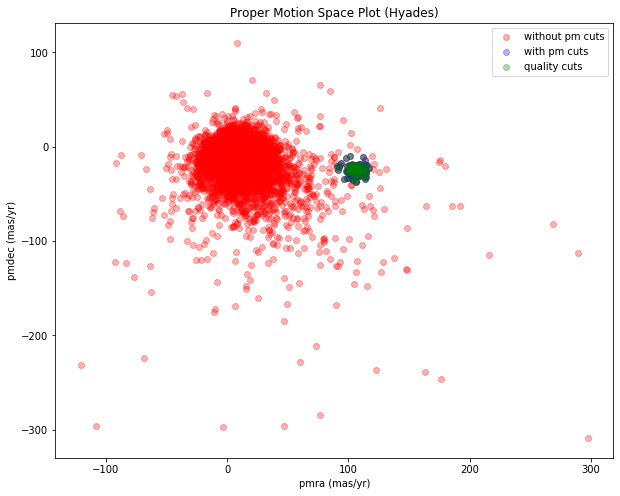

In [6]:
# plotting the proper motion in RA and Dec of potential cluster members based on a selection in position and parallax
plt.figure(figsize=(10, 8))
hyades_pm_results = hyades_pm.get_results()
hyades_nopm_results = hyades_nopm.get_results()
hyades_qual_results = hyades_qual.get_results()

# find number of points
print("Number of points without cuts on proper motion:", len(hyades_nopm_results['source_id']))
print("Number of points with cuts on proper motion:", len(hyades_pm_results['source_id']))
print("Number of points with quality cuts:", len(hyades_qual_results['source_id']))

plt.scatter(hyades_nopm_results['pmra'], hyades_nopm_results['pmdec'], color='r', alpha=0.3, label = 'without pm cuts')
plt.scatter(hyades_pm_results['pmra'], hyades_pm_results['pmdec'], color='b', alpha=0.3, label = 'with pm cuts')
plt.scatter(hyades_qual_results['pmra'], hyades_qual_results['pmdec'], color='g', alpha=0.3, label = 'quality cuts')

plt.legend()
plt.xlabel('pmra (mas/yr)')
plt.ylabel('pmdec (mas/yr)')
plt.title('Proper Motion Space Plot (Hyades)')
plt.show()

### Color-Magnitude Diagram

In [7]:
# plotting the color-magnitude diagram for potential cluster members with and without cuts on proper motion
m_pm = [5*(math.log10(x/1000)) for x in hyades_pm_results['parallax']]
m_nopm = [5*(math.log10(x/1000)) for x in hyades_nopm_results['parallax']]
m_qual = [5*(math.log10(x/1000)) for x in hyades_qual_results['parallax']]

# absolute magnitude
extinction = 3.1*(0.001)
mag_pm = hyades_pm_results['phot_g_mean_mag'] + 5 + m_pm - extinction
mag_nopm = hyades_nopm_results['phot_g_mean_mag'] + 5 + m_nopm - extinction
mag_qual = hyades_qual_results['phot_g_mean_mag'] + 5 + m_qual - extinction

color_pm = hyades_pm_results['phot_bp_mean_mag'] - hyades_pm_results['phot_rp_mean_mag']
color_nopm = hyades_nopm_results['phot_bp_mean_mag'] - hyades_nopm_results['phot_rp_mean_mag']
color_qual = hyades_qual_results['phot_bp_mean_mag'] - hyades_qual_results['phot_rp_mean_mag']

Text(0.5, 1.0, 'Color Absolute Magnitude Diagram (Hyades)')

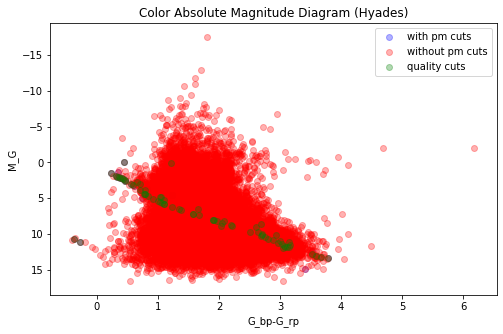

In [8]:
plt.figure(figsize=(8, 5))

plt.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
plt.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
plt.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
plt.gca().invert_yaxis()

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
plt.title('Color Absolute Magnitude Diagram (Hyades)')

### MIST Isochrones

In [9]:
## loading data

# metallicity = 0.13
hyades_isocmd1 = pd.read_csv('hyades0_13.iso.cmd',comment='#',delim_whitespace= True)
hyades_isocmd1 = hyades_isocmd1.T.reset_index(drop=True).T
new_columns = ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 
               'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 
               'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp', 
               'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 
               'Gaia_BP_MAWb', 'Gaia_BP_MAWf', 'Gaia_RP_MAW', 'TESS', 'phase']
hyades_isocmd1.columns = new_columns

# metallicity = 0.07
hyades_isocmd2 = pd.read_csv('hyades0_07.iso.cmd',comment='#',delim_whitespace= True)
hyades_isocmd2 = hyades_isocmd2.T.reset_index(drop=True).T
hyades_isocmd2.columns = new_columns

# metallicity = 0.2
hyades_isocmd3 = pd.read_csv('hyades0_2.iso.cmd',comment='#',delim_whitespace= True)
hyades_isocmd3 = hyades_isocmd3.T.reset_index(drop=True).T
hyades_isocmd3.columns = new_columns

In [10]:
# metallicity = 0.13
hyades1age1_bp = hyades_isocmd1['Gaia_BP_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 8.5]
hyades1age2_bp = hyades_isocmd1['Gaia_BP_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 8.9]
hyades1age3_bp = hyades_isocmd1['Gaia_BP_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 9.5]
hyades1age1_rp = hyades_isocmd1['Gaia_RP_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 8.5]
hyades1age2_rp = hyades_isocmd1['Gaia_RP_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 8.9]
hyades1age3_rp = hyades_isocmd1['Gaia_RP_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 9.5]
hyades1age1_mg = hyades_isocmd1['Gaia_G_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 8.5]
hyades1age2_mg = hyades_isocmd1['Gaia_G_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 8.9]
hyades1age3_mg = hyades_isocmd1['Gaia_G_DR2Rev'][hyades_isocmd1['log10_isochrone_age_yr'] == 9.5]

# metallicity = 0.07
hyades2age1_bp = hyades_isocmd2['Gaia_BP_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 8.5]
hyades2age2_bp = hyades_isocmd2['Gaia_BP_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 8.9]
hyades2age3_bp = hyades_isocmd2['Gaia_BP_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 9.5]
hyades2age1_rp = hyades_isocmd2['Gaia_RP_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 8.5]
hyades2age2_rp = hyades_isocmd2['Gaia_RP_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 8.9]
hyades2age3_rp = hyades_isocmd2['Gaia_RP_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 9.5]
hyades2age1_mg = hyades_isocmd2['Gaia_G_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 8.5]
hyades2age2_mg = hyades_isocmd2['Gaia_G_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 8.9]
hyades2age3_mg = hyades_isocmd2['Gaia_G_DR2Rev'][hyades_isocmd2['log10_isochrone_age_yr'] == 9.5]

# metallicity = 0.2
hyades3age1_bp = hyades_isocmd3['Gaia_BP_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 8.5]
hyades3age2_bp = hyades_isocmd3['Gaia_BP_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 8.9]
hyades3age3_bp = hyades_isocmd3['Gaia_BP_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 9.5]
hyades3age1_rp = hyades_isocmd3['Gaia_RP_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 8.5]
hyades3age2_rp = hyades_isocmd3['Gaia_RP_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 8.9]
hyades3age3_rp = hyades_isocmd3['Gaia_RP_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 9.5]
hyades3age1_mg = hyades_isocmd3['Gaia_G_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 8.5]
hyades3age2_mg = hyades_isocmd3['Gaia_G_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 8.9]
hyades3age3_mg = hyades_isocmd3['Gaia_G_DR2Rev'][hyades_isocmd3['log10_isochrone_age_yr'] == 9.5]

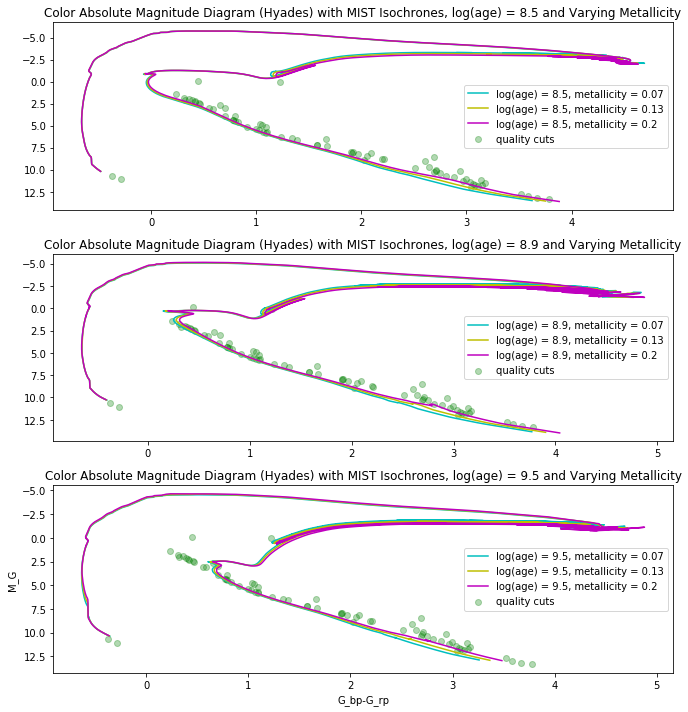

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

## log(age) = 8.5, varying metallicity
# ax1.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax1.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax1.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax1.invert_yaxis()

ax1.plot(hyades2age1_bp - hyades2age1_rp, hyades2age1_mg, color = 'c', label = 'log(age) = 8.5, metallicity = 0.07')
ax1.plot(hyades1age1_bp - hyades1age1_rp, hyades1age1_mg, color = 'y', label = 'log(age) = 8.5, metallicity = 0.13')
ax1.plot(hyades3age1_bp - hyades3age1_rp, hyades3age1_mg, color = 'm', label = 'log(age) = 8.5, metallicity = 0.2')

ax1.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax1.set_title('Color Absolute Magnitude Diagram (Hyades) with MIST Isochrones, log(age) = 8.5 and Varying Metallicity')

## log(age) = 8.9, varying metallicity
# ax2.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax2.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax2.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax2.invert_yaxis()

ax2.plot(hyades2age2_bp - hyades2age2_rp, hyades2age2_mg, color = 'c', label = 'log(age) = 8.9, metallicity = 0.07')
ax2.plot(hyades1age2_bp - hyades1age2_rp, hyades1age2_mg, color = 'y', label = 'log(age) = 8.9, metallicity = 0.13')
ax2.plot(hyades3age2_bp - hyades3age2_rp, hyades3age2_mg, color = 'm', label = 'log(age) = 8.9, metallicity = 0.2')

ax2.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax2.set_title('Color Absolute Magnitude Diagram (Hyades) with MIST Isochrones, log(age) = 8.9 and Varying Metallicity')


## log(age) = 9.5, varying metallicity
# ax3.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax3.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax3.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax3.invert_yaxis()

ax3.plot(hyades2age3_bp - hyades2age3_rp, hyades2age3_mg, color = 'c', label = 'log(age) = 9.5, metallicity = 0.07')
ax3.plot(hyades1age3_bp - hyades1age3_rp, hyades1age3_mg, color = 'y', label = 'log(age) = 9.5, metallicity = 0.13')
ax3.plot(hyades3age3_bp - hyades3age3_rp, hyades3age3_mg, color = 'm', label = 'log(age) = 9.5, metallicity = 0.2')

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax3.set_title('Color Absolute Magnitude Diagram (Hyades) with MIST Isochrones, log(age) = 9.5 and Varying Metallicity')

plt.tight_layout()

### Comparing MIST Isochrone with PARSEC Isochrone

In [12]:
# loading PARSEC data
hyades_parsec = pd.read_csv('http://stev.oapd.inaf.it/tmp/output795958378891.dat',comment='#',delim_whitespace= True)
hyades_parsec = hyades_parsec.T.reset_index(drop=True).T
parsec_columns = ['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label', 
               'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc',
               'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag']
hyades_parsec.columns = parsec_columns
hyades_parsec = hyades_parsec[:-50] # get rid of bottom columns bc haven't implemented post-AGB evolution yet
hyades_parsec.tail()

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag
652,0.019473,0.13,8.9,2.543333,2.58609,1.318,3.992,3.3885,-0.928,8.0,...,0.3261,0.006341,0.00304,0.007766,7.821,0.02399,-5.210,-2.754,-0.817,-4.036
653,0.019473,0.13,8.9,2.543334,2.58609,1.315,3.844,3.4329,-0.604,8.0,...,0.3261,0.006341,0.00304,0.007766,7.821,0.02399,-4.841,-3.306,-1.700,-4.455
654,0.019473,0.13,8.9,2.543334,2.58609,1.310,3.762,3.4583,-0.421,8.0,...,0.3261,0.006341,0.00304,0.007766,7.821,0.02399,-4.634,-3.240,-1.793,-4.345
655,0.019473,0.13,8.9,2.543336,2.58609,1.304,3.802,3.4462,-0.512,8.0,...,0.3261,0.006342,0.00304,0.007766,7.822,0.02399,-4.736,-3.272,-1.749,-4.399
656,0.019473,0.13,8.9,2.543337,2.58609,1.295,3.877,3.4235,-0.680,8.0,...,0.3261,0.006342,0.00304,0.007766,7.822,0.02399,-4.921,-3.319,-1.651,-4.485


Text(0.5, 1.0, 'Color Absolute Magnitude Diagram (Hyades) with MIST & PARSEC isochrones ([Fe/H]=0.13, log(age)=8.9)')

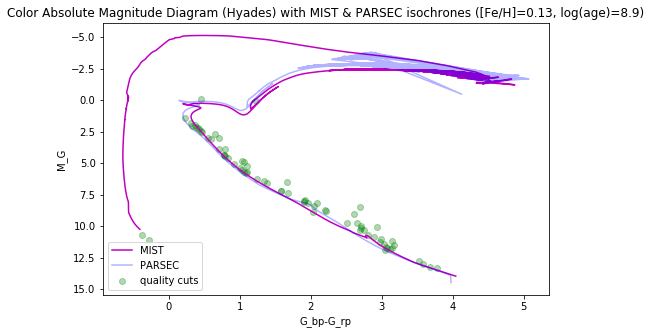

In [13]:
plt.figure(figsize=(8, 5))

# plt.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# plt.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
plt.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
plt.gca().invert_yaxis()

# plot most accurate MIST isochrone
plt.plot(hyades3age2_bp - hyades3age2_rp, hyades3age2_mg, color = 'm', label = 'MIST')

# plot PARSEC isochrone
plt.plot(hyades_parsec['G_BPmag'] - hyades_parsec['G_RPmag'],
            hyades_parsec['Gmag'], color='b', alpha=0.3, label= 'PARSEC')

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
plt.title('Color Absolute Magnitude Diagram (Hyades) with MIST & PARSEC isochrones ([Fe/H]=0.13, log(age)=8.9)')

## Hyades Analysis
Hyades was the most clear in seeing the cluster members in phase space. The proper motion cut was significant in making the proper motion plot and color-magnitude diagram cleaner and the quality cut helped make both the plot and diagram more precise. In the end, I was only able to get 73 stars. Because Hyades is a fairly young cluster, it contains almost all main sequence stars and does not appear to have any binaries from my HRD. According to my MIST isochrone plots, log(age)=8.9 and metallicity=0.2 seem to be the most consistent with my data, whereas Babusiaux et al. 2018 estimates log(age)=8.9 and metallicity=0.13. The theoretical MIST model, PARSEC model, and the data all look very similar for this cluster.

# M67

### Loading queries

In [14]:
# without cuts on proper motion
m67_nopm =  Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',132.825,11.48,0.5))=1 \
AND parallax BETWEEN 0.5 AND 2;")

INFO: Query finished. [astroquery.utils.tap.core]


In [15]:
# filter out by location, rad = 2deg, and proper motion
m67_pm = Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',132.825,11.48,0.5))=1 \
AND parallax BETWEEN 0.5 AND 2 \
AND pmra BETWEEN -15 AND -5 \
AND pmdec BETWEEN -10 AND 0;")

INFO: Query finished. [astroquery.utils.tap.core]


In [16]:
# quality cuts
m67_qual = Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',132.825,11.48,0.5))=1 \
AND parallax BETWEEN 0.5 AND 2 \
AND visibility_periods_used>8 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor> 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor< 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND parallax_over_error>10 \
AND pmra BETWEEN -15 AND -5 \
AND pmdec BETWEEN -10 AND 0;")

INFO: Query finished. [astroquery.utils.tap.core]


### Proper Motion Space Plot

Number of points without cuts on proper motion: 2834
Number of points with cuts on proper motion: 1347
Number of points with quality cuts: 776


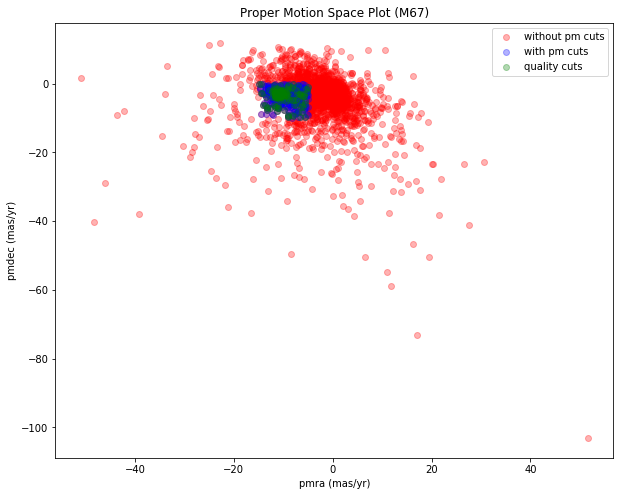

In [17]:
# plotting the proper motion in RA and Dec of potential cluster members based on a selection in position and parallax
plt.figure(figsize=(10, 8))
m67_pm_results = m67_pm.get_results()
m67_nopm_results = m67_nopm.get_results()
m67_qual_results = m67_qual.get_results()

# find number of points
print("Number of points without cuts on proper motion:", len(m67_nopm_results['source_id']))
print("Number of points with cuts on proper motion:", len(m67_pm_results['source_id']))
print("Number of points with quality cuts:", len(m67_qual_results['source_id']))

plt.scatter(m67_nopm_results['pmra'], m67_nopm_results['pmdec'], color='r', alpha=0.3, label = 'without pm cuts')
plt.scatter(m67_pm_results['pmra'], m67_pm_results['pmdec'], color='b', alpha=0.3, label = 'with pm cuts')
plt.scatter(m67_qual_results['pmra'], m67_qual_results['pmdec'], color='g', alpha=0.3, label = 'quality cuts')

plt.legend()
plt.xlabel('pmra (mas/yr)')
plt.ylabel('pmdec (mas/yr)')
plt.title('Proper Motion Space Plot (M67)')
plt.show()

### Color-Magnitude Diagram

In [18]:
# plotting the color-magnitude diagram for potential cluster members with and without cuts on proper motion
m_pm = [5*(math.log10(x/1000)) for x in m67_pm_results['parallax']]
m_nopm = [5*(math.log10(x/1000)) for x in m67_nopm_results['parallax']]
m_qual = [5*(math.log10(x/1000)) for x in m67_qual_results['parallax']]

# absolute magnitude
extinction = 3.1*(0.037)
mag_pm = m67_pm_results['phot_g_mean_mag'] + 5 + m_pm - extinction
mag_nopm = m67_nopm_results['phot_g_mean_mag'] + 5 + m_nopm - extinction
mag_qual = m67_qual_results['phot_g_mean_mag'] + 5 + m_qual - extinction

color_pm = m67_pm_results['phot_bp_mean_mag'] - m67_pm_results['phot_rp_mean_mag']
color_nopm = m67_nopm_results['phot_bp_mean_mag'] - m67_nopm_results['phot_rp_mean_mag']
color_qual = m67_qual_results['phot_bp_mean_mag'] - m67_qual_results['phot_rp_mean_mag']

Text(0.5, 1.0, 'Color Absolute Magnitude Diagram (M67)')

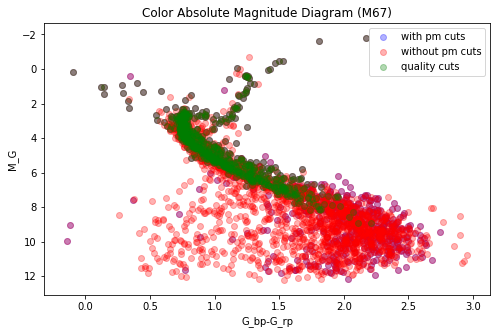

In [19]:
plt.figure(figsize=(8, 5))

plt.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
plt.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
plt.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
plt.gca().invert_yaxis()

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
plt.title('Color Absolute Magnitude Diagram (M67)')

### MIST Isochrones

In [20]:
## loading data

# metallicity = 0.03
m67_isocmd1 = pd.read_csv('m67_03.iso.cmd',comment='#',delim_whitespace= True)
m67_isocmd1 = m67_isocmd1.T.reset_index(drop=True).T
m67_isocmd1.columns = new_columns

# metallicity = 0.00
m67_isocmd2 = pd.read_csv('m67_0.iso.cmd',comment='#',delim_whitespace= True)
m67_isocmd2 = m67_isocmd2.T.reset_index(drop=True).T
m67_isocmd2.columns = new_columns

# metallicity = 0.05
m67_isocmd3 = pd.read_csv('m67_05.iso.cmd',comment='#',delim_whitespace= True)
m67_isocmd3 = m67_isocmd3.T.reset_index(drop=True).T
m67_isocmd3.columns = new_columns

In [21]:
# metallicity = 0.03
m671age1_bp = m67_isocmd1['Gaia_BP_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 9.0]
m671age2_bp = m67_isocmd1['Gaia_BP_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 9.5]
m671age3_bp = m67_isocmd1['Gaia_BP_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 10.0]
m671age1_rp = m67_isocmd1['Gaia_RP_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 9.0]
m671age2_rp = m67_isocmd1['Gaia_RP_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 9.5]
m671age3_rp = m67_isocmd1['Gaia_RP_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 10.0]
m671age1_mg = m67_isocmd1['Gaia_G_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 9.0]
m671age2_mg = m67_isocmd1['Gaia_G_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 9.5]
m671age3_mg = m67_isocmd1['Gaia_G_DR2Rev'][m67_isocmd1['log10_isochrone_age_yr'] == 10.0]

# metallicity = 0.00
m672age1_bp = m67_isocmd2['Gaia_BP_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 9.0]
m672age2_bp = m67_isocmd2['Gaia_BP_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 9.5]
m672age3_bp = m67_isocmd2['Gaia_BP_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 10.0]
m672age1_rp = m67_isocmd2['Gaia_RP_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 9.0]
m672age2_rp = m67_isocmd2['Gaia_RP_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 9.5]
m672age3_rp = m67_isocmd2['Gaia_RP_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 10.0]
m672age1_mg = m67_isocmd2['Gaia_G_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 9.0]
m672age2_mg = m67_isocmd2['Gaia_G_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 9.5]
m672age3_mg = m67_isocmd2['Gaia_G_DR2Rev'][m67_isocmd2['log10_isochrone_age_yr'] == 10.0]

# metallicity = 0.05
m673age1_bp = m67_isocmd3['Gaia_BP_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 9.0]
m673age2_bp = m67_isocmd3['Gaia_BP_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 9.5]
m673age3_bp = m67_isocmd3['Gaia_BP_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 10.0]
m673age1_rp = m67_isocmd3['Gaia_RP_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 9.0]
m673age2_rp = m67_isocmd3['Gaia_RP_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 9.5]
m673age3_rp = m67_isocmd3['Gaia_RP_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 10.0]
m673age1_mg = m67_isocmd3['Gaia_G_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 9.0]
m673age2_mg = m67_isocmd3['Gaia_G_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 9.5]
m673age3_mg = m67_isocmd3['Gaia_G_DR2Rev'][m67_isocmd3['log10_isochrone_age_yr'] == 10.0]

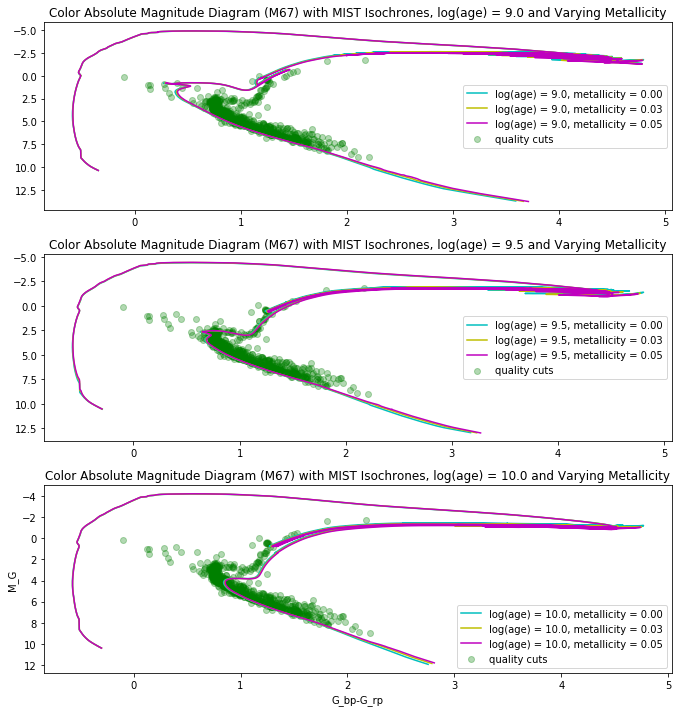

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

## log(age) = 8.5, varying metallicity
# ax1.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax1.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax1.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax1.invert_yaxis()

ax1.plot(m672age1_bp - m672age1_rp, m672age1_mg, color = 'c', label = 'log(age) = 9.0, metallicity = 0.00')
ax1.plot(m671age1_bp - m671age1_rp, m671age1_mg, color = 'y', label = 'log(age) = 9.0, metallicity = 0.03')
ax1.plot(m673age1_bp - m673age1_rp, m673age1_mg, color = 'm', label = 'log(age) = 9.0, metallicity = 0.05')

ax1.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax1.set_title('Color Absolute Magnitude Diagram (M67) with MIST Isochrones, log(age) = 9.0 and Varying Metallicity')

## log(age) = 8.9, varying metallicity
# ax2.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax2.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax2.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax2.invert_yaxis()

ax2.plot(m672age2_bp - m672age2_rp, m672age2_mg, color = 'c', label = 'log(age) = 9.5, metallicity = 0.00')
ax2.plot(m671age2_bp - m671age2_rp, m671age2_mg, color = 'y', label = 'log(age) = 9.5, metallicity = 0.03')
ax2.plot(m673age2_bp - m673age2_rp, m673age2_mg, color = 'm', label = 'log(age) = 9.5, metallicity = 0.05')

ax2.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax2.set_title('Color Absolute Magnitude Diagram (M67) with MIST Isochrones, log(age) = 9.5 and Varying Metallicity')


## log(age) = 9.5, varying metallicity
# ax3.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax3.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax3.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax3.invert_yaxis()

ax3.plot(m672age3_bp - m672age3_rp, m672age3_mg, color = 'c', label = 'log(age) = 10.0, metallicity = 0.00')
ax3.plot(m671age3_bp - m671age3_rp, m671age3_mg, color = 'y', label = 'log(age) = 10.0, metallicity = 0.03')
ax3.plot(m673age3_bp - m673age3_rp, m673age3_mg, color = 'm', label = 'log(age) = 10.0, metallicity = 0.05')

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax3.set_title('Color Absolute Magnitude Diagram (M67) with MIST Isochrones, log(age) = 10.0 and Varying Metallicity')

plt.tight_layout()

### Comparing MIST Isochrone to PARSEC Isochrone

In [23]:
# loading PARSEC data
m67_parsec = pd.read_csv('http://stev.oapd.inaf.it/tmp/output724275969042.dat',comment='#',delim_whitespace= True)
m67_parsec = m67_parsec.T.reset_index(drop=True).T
parsec_columns = ['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label', 
               'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc',
               'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag']
m67_parsec.columns = parsec_columns
m67_parsec = m67_parsec[:-1] # get rid of last column bc haven't implemented post-AGB evolution yet

Text(0.5, 1.0, 'Color Absolute Magnitude Diagram (M67) with MIST & PARSEC isochrones ([Fe/H]=0.03, log(age)=9.54)')

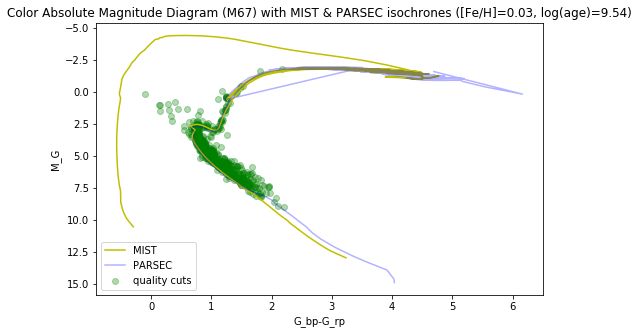

In [24]:
plt.figure(figsize=(8, 5))

# plt.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# plt.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
plt.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
plt.gca().invert_yaxis()

# plot most accurate MIST isochrone
plt.plot(m671age2_bp - m671age2_rp, m671age2_mg, color = 'y', label = 'MIST')

# plot PARSEC isochrone
plt.plot(m67_parsec['G_BPmag'] - m67_parsec['G_RPmag'],
            m67_parsec['Gmag'], color='b', alpha=0.3, label= 'PARSEC')

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
plt.title('Color Absolute Magnitude Diagram (M67) with MIST & PARSEC isochrones ([Fe/H]=0.03, log(age)=9.54)')

## M67 Analysis
It was more difficult to see the physical cluster in phase space for M67. While the proper motion cut created a cleaner proper motion space plot and color magnitude diagram, the quality cut was significant in creating a cleaner plot and diagram. There are still a lot of main sequence stars in M67, but it also looks to include some binaries. It looks that it has begun its main sequence turn off, including subgiants and giants. From my MIST isochrone plots, it seems that log(age)=9.5, metallicity=0.03 was the most consistent with the data, which is the same estimate as Babusiaux et al. 2018. We can see that the MIST model, the PARSEC model, and the data are all very similar to each other, except that the MIST model and PARSEC model deviate slightly from each other.

# NGC 6397

### Loading queries

In [25]:
# without cuts on proper motion
ngc_nopm =  Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',265.24,-53.4027,0.5))=1 \
AND parallax BETWEEN 0 AND 0.5;")

INFO: Query finished. [astroquery.utils.tap.core]


In [26]:
# filter out by location, rad = 2deg, and proper motion
ngc_pm = Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',265.24,-53.4027,0.5))=1 \
AND parallax BETWEEN 0 AND 0.5 \
AND pmra BETWEEN 0 AND 5 \
AND pmdec BETWEEN -20 AND -10;")

INFO: Query finished. [astroquery.utils.tap.core]


In [27]:
# quality cuts
ngc_qual = Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',265.24,-53.4027,0.5))=1 \
AND parallax BETWEEN 0 and 0.5 \
AND visibility_periods_used>8 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor> 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor< 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND parallax_over_error>2 \
AND pmra BETWEEN 0 AND 5 \
AND pmdec BETWEEN -20 AND -10;")

INFO: Query finished. [astroquery.utils.tap.core]


### Proper Motion Space Plot

Number of points without cuts on proper motion: 47684
Number of points with cuts on proper motion: 13568
Number of points with quality cuts: 4458


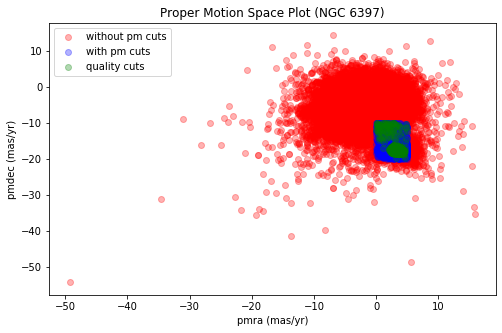

In [28]:
# plotting the proper motion in RA and Dec of potential cluster members based on a selection in position and parallax
plt.figure(figsize=(8, 5))
ngc_pm_results = ngc_pm.get_results()
ngc_nopm_results = ngc_nopm.get_results()
ngc_qual_results = ngc_qual.get_results()

# find number of points
print("Number of points without cuts on proper motion:", len(ngc_nopm_results['source_id']))
print("Number of points with cuts on proper motion:", len(ngc_pm_results['source_id']))
print("Number of points with quality cuts:", len(ngc_qual_results['source_id']))

plt.scatter(ngc_nopm_results['pmra'], ngc_nopm_results['pmdec'], color='r', alpha=0.3, label = 'without pm cuts')
plt.scatter(ngc_pm_results['pmra'], ngc_pm_results['pmdec'], color='b', alpha=0.3, label = 'with pm cuts')
plt.scatter(ngc_qual_results['pmra'], ngc_qual_results['pmdec'], color='g', alpha=0.3, label = 'quality cuts')

plt.legend()
plt.xlabel('pmra (mas/yr)')
plt.ylabel('pmdec (mas/yr)')
plt.title('Proper Motion Space Plot (NGC 6397)')
plt.show()

### Color-magnitude Diagram

In [29]:
# Try plotting the color-magnitude diagram for potential cluster members with and without cuts on proper motion
m_pm = [5*(math.log10(x/1000)) for x in ngc_pm_results['parallax']]
m_nopm = [5*(math.log10(x/1000)) for x in ngc_nopm_results['parallax']]
m_qual = [5*(math.log10(x/1000)) for x in ngc_qual_results['parallax']]

# absolute magnitude
extinction = 3.1*0.18
mag_pm = ngc_pm_results['phot_g_mean_mag'] + 5 + m_pm - extinction
mag_nopm = ngc_nopm_results['phot_g_mean_mag'] + 5 + m_nopm - extinction
mag_qual = ngc_qual_results['phot_g_mean_mag'] + 5 + m_qual - extinction

color_pm = ngc_pm_results['phot_bp_mean_mag'] - ngc_pm_results['phot_rp_mean_mag']
color_nopm = ngc_nopm_results['phot_bp_mean_mag'] - ngc_nopm_results['phot_rp_mean_mag']
color_qual = ngc_qual_results['phot_bp_mean_mag'] - ngc_qual_results['phot_rp_mean_mag']

Text(0.5, 1.0, 'Color Absolute Magnitude Diagram (NGC 6397)')

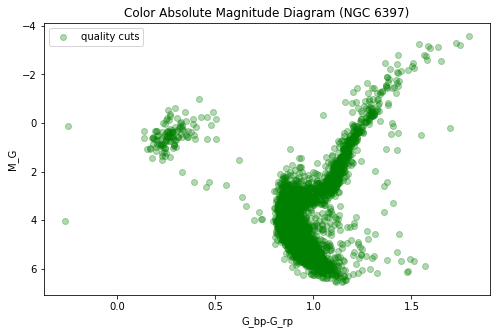

In [30]:
plt.figure(figsize=(8, 5))
# plt.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# plt.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
plt.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
plt.gca().invert_yaxis()

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
plt.title('Color Absolute Magnitude Diagram (NGC 6397)')

### MIST Isochrones

In [31]:
## loading data

# metallicity = -2.02
ngc_isocmd1 = pd.read_csv('ngc_2_02.iso.cmd',comment='#',delim_whitespace= True)
ngc_isocmd1 = ngc_isocmd1.T.reset_index(drop=True).T
ngc_isocmd1.columns = new_columns

# metallicity = -2.5
ngc_isocmd2 = pd.read_csv('ngc_2_5.iso.cmd',comment='#',delim_whitespace= True)
ngc_isocmd2 = ngc_isocmd2.T.reset_index(drop=True).T
ngc_isocmd2.columns = new_columns

# metallicity = -1.5
ngc_isocmd3 = pd.read_csv('ngc_1_5.iso.cmd',comment='#',delim_whitespace= True)
ngc_isocmd3 = ngc_isocmd3.T.reset_index(drop=True).T
ngc_isocmd3.columns = new_columns

In [32]:
# metallicity = -2.02
ngc1age1_bp = ngc_isocmd1['Gaia_BP_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 9.5]
ngc1age2_bp = ngc_isocmd1['Gaia_BP_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 10.0]
ngc1age3_bp = ngc_isocmd1['Gaia_BP_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 10.3]
ngc1age1_rp = ngc_isocmd1['Gaia_RP_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 9.5]
ngc1age2_rp = ngc_isocmd1['Gaia_RP_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 10.0]
ngc1age3_rp = ngc_isocmd1['Gaia_RP_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 10.3]
ngc1age1_mg = ngc_isocmd1['Gaia_G_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 9.5]
ngc1age2_mg = ngc_isocmd1['Gaia_G_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 10.0]
ngc1age3_mg = ngc_isocmd1['Gaia_G_DR2Rev'][ngc_isocmd1['log10_isochrone_age_yr'] == 10.3]

# metallicity = -2.5
ngc2age1_bp = ngc_isocmd2['Gaia_BP_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 9.5]
ngc2age2_bp = ngc_isocmd2['Gaia_BP_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 10.0]
ngc2age3_bp = ngc_isocmd2['Gaia_BP_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 10.3]
ngc2age1_rp = ngc_isocmd2['Gaia_RP_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 9.5]
ngc2age2_rp = ngc_isocmd2['Gaia_RP_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 10.0]
ngc2age3_rp = ngc_isocmd2['Gaia_RP_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 10.3]
ngc2age1_mg = ngc_isocmd2['Gaia_G_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 9.5]
ngc2age2_mg = ngc_isocmd2['Gaia_G_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 10.0]
ngc2age3_mg = ngc_isocmd2['Gaia_G_DR2Rev'][ngc_isocmd2['log10_isochrone_age_yr'] == 10.3]

# metallicity = -1.5
ngc3age1_bp = ngc_isocmd3['Gaia_BP_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 9.5]
ngc3age2_bp = ngc_isocmd3['Gaia_BP_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 10.0]
ngc3age3_bp = ngc_isocmd3['Gaia_BP_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 10.3]
ngc3age1_rp = ngc_isocmd3['Gaia_RP_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 9.5]
ngc3age2_rp = ngc_isocmd3['Gaia_RP_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 10.0]
ngc3age3_rp = ngc_isocmd3['Gaia_RP_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 10.3]
ngc3age1_mg = ngc_isocmd3['Gaia_G_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 9.5]
ngc3age2_mg = ngc_isocmd3['Gaia_G_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 10.0]
ngc3age3_mg = ngc_isocmd3['Gaia_G_DR2Rev'][ngc_isocmd3['log10_isochrone_age_yr'] == 10.3]

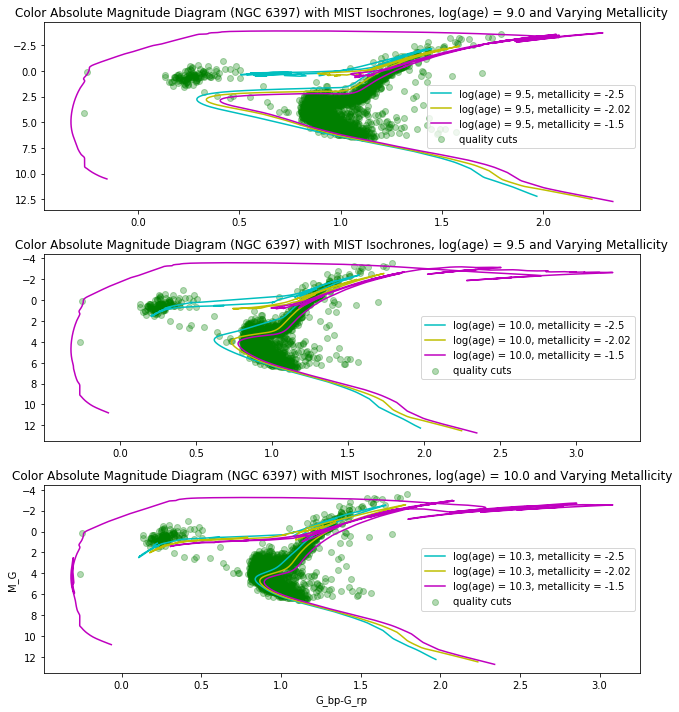

In [33]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

## log(age) = 9.5, varying metallicity
# ax1.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax1.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax1.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax1.invert_yaxis()

ax1.plot(ngc2age1_bp - ngc2age1_rp, ngc2age1_mg, color = 'c', label = 'log(age) = 9.5, metallicity = -2.5')
ax1.plot(ngc1age1_bp - ngc1age1_rp, ngc1age1_mg, color = 'y', label = 'log(age) = 9.5, metallicity = -2.02')
ax1.plot(ngc3age1_bp - ngc3age1_rp, ngc3age1_mg, color = 'm', label = 'log(age) = 9.5, metallicity = -1.5')

ax1.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax1.set_title('Color Absolute Magnitude Diagram (NGC 6397) with MIST Isochrones, log(age) = 9.0 and Varying Metallicity')

## log(age) = 10.0, varying metallicity
# ax2.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax2.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax2.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax2.invert_yaxis()

ax2.plot(ngc2age2_bp - ngc2age2_rp, ngc2age2_mg, color = 'c', label = 'log(age) = 10.0, metallicity = -2.5')
ax2.plot(ngc1age2_bp - ngc1age2_rp, ngc1age2_mg, color = 'y', label = 'log(age) = 10.0, metallicity = -2.02')
ax2.plot(ngc3age2_bp - ngc3age2_rp, ngc3age2_mg, color = 'm', label = 'log(age) = 10.0, metallicity = -1.5')

ax2.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax2.set_title('Color Absolute Magnitude Diagram (NGC 6397) with MIST Isochrones, log(age) = 9.5 and Varying Metallicity')


## log(age) = 10.3, varying metallicity
# ax3.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# ax3.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
ax3.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
ax3.invert_yaxis()

ax3.plot(ngc2age3_bp - ngc2age3_rp, ngc2age3_mg, color = 'c', label = 'log(age) = 10.3, metallicity = -2.5')
ax3.plot(ngc1age3_bp - ngc1age3_rp, ngc1age3_mg, color = 'y', label = 'log(age) = 10.3, metallicity = -2.02')
ax3.plot(ngc3age3_bp - ngc3age3_rp, ngc3age3_mg, color = 'm', label = 'log(age) = 10.3, metallicity = -1.5')

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
ax3.set_title('Color Absolute Magnitude Diagram (NGC 6397) with MIST Isochrones, log(age) = 10.0 and Varying Metallicity')

plt.tight_layout()

### Comparing MIST Isochrone to PARSEC Isochrone

In [34]:
# loading PARSEC data
ngc_parsec = pd.read_csv('http://stev.oapd.inaf.it/tmp/output401126948258.dat',comment='#',delim_whitespace= True)
ngc_parsec = ngc_parsec.T.reset_index(drop=True).T
parsec_columns = ['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label', 
               'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc',
               'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag']
ngc_parsec.columns = parsec_columns
ngc_parsec = ngc_parsec[:-1] # get rid of last column bc haven't implemented post-AGB evolution yet

Text(0.5, 1.0, 'Color Absolute Magnitude Diagram (ngc) with MIST & PARSEC isochrones ([Fe/H]=-2.02, log(age)=13.5Gyr)')

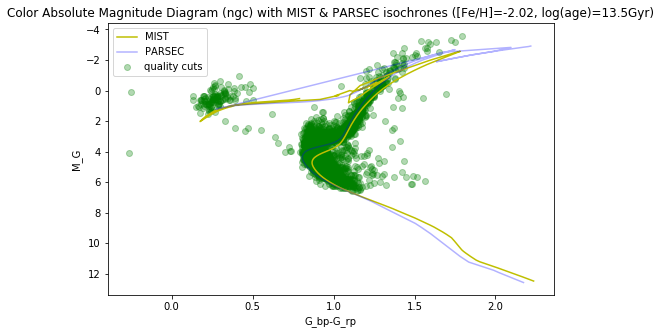

In [35]:
plt.figure(figsize=(8, 5))

# plt.scatter(color_pm, mag_pm, color='b', alpha=0.3, label= 'with pm cuts')
# plt.scatter(color_nopm, mag_nopm, color='r', alpha=0.3, label= 'without pm cuts')
plt.scatter(color_qual, mag_qual, color='g', alpha=0.3, label= 'quality cuts')
plt.gca().invert_yaxis()

# plot most accurate MIST isochrone
plt.plot(ngc1age3_bp - ngc1age3_rp, ngc1age3_mg, color = 'y', label = 'MIST')

# plot PARSEC isochrone
plt.plot(ngc_parsec['G_BPmag'] - ngc_parsec['G_RPmag'],
            ngc_parsec['Gmag'], color='b', alpha=0.3, label= 'PARSEC')

plt.legend()
plt.xlabel('G_bp-G_rp')
plt.ylabel('M_G')
plt.title('Color Absolute Magnitude Diagram (ngc) with MIST & PARSEC isochrones ([Fe/H]=-2.02, log(age)=13.5Gyr)')

## NGC 6397 Analysis
Like the other clusters, the proper motion cut was important in cleaning up the diagram and plot and the quality cut was significant in filtering for a cluster for NGC 6397. Because NGC 6397 is very far and the data is lower quality and has more error, I also lifted parallax_over_error to be less strict. Furthermore, NGC 6397 is a much older cluster and we see that there are many stars along the giant branch and not as many in the main sequence. Here, the MIST model and PARSEC model do not match the data as well compared to M67 and Hyades. The theoretical models aren't very similar to each other, either. This is most likely due to uncertainties of the parallaxes, which affects the absolute magnitude for this cluster. While my isochrones do not match my data well, log(age) = 10.3 and metallicity = -2.02 was the most consistent with the data than the other isochrones, and Babusiaux et al. 2018 estimated log(age) = 13.5 Gyr and metallicity = -2.02. 